In [30]:
import numpy as np
import matplotlib.pyplot as plt

from module.tools import make_samples
from module.generated_models import adv_grs, pkf_adv_grs
from module.multivariate import *

from model import AdvectionGRS

In [31]:
species_name = ['ROC','RP','NO','NO2','O3','SN(G)N']

class EnKF_Advection_GRS(MultivariateEnKF1D, adv_grs):
    def __init__(self, **kwargs):
        adv_grs.__init__(self, **kwargs)
        MultivariateEnKF1D.__init__(self, species_name) 
        
class PKF_Advection_GRS(MultivariatePKF1D, pkf_adv_grs):
    def __init__(self, **kwargs):
        pkf_adv_grs.__init__(self, **kwargs)
        MultivariatePKF1D.__init__(self, species_name)

# 1. GRS (generic reaction set) 

The GRS is a reduced order chemical model for atmospheric chemistry. More detail in the paper : 
https://gmd.copernicus.org/articles/9/393/2016/

## 1.1 Creating an initial state from a long forecast in a box-model

4 weeks forecast

In [32]:
Nx = 241
enkf = EnKF_Advection_GRS(shape=(Nx,),u=np.zeros(Nx,))
enkf.set_dt(0.001)

In [4]:
times = enkf.window(24*7*4)
saved_times = list(times[::100]) + [times[-1]]

state0 = np.zeros((6,Nx))
forecast = enkf.forecast(times, state0, saved_times)

KeyboardInterrupt: 

In [ ]:
times = list(forecast.keys())
forecast = np.array(list(forecast.values()))

plt.figure(figsize=(24*0.7,7*0.7))
for i, name in enumerate(species_name): plt.plot(times, forecast[:,i,150],label=name)
plt.legend();

state0 = forecast[-1] ; 

In [ ]:
import pickle
pickle.dump(state0,open('grs_data/grs_state0.pkl','wb'))

# 2. Multivariate forecast (EnKF and PKF) of the GRS model

## 2.1 advection configuration 

In [33]:
D = 1000  #km
u_amp = 15 #kmh
u_mean = 35  #kmh
domain = enkf ; dx = domain.dx[0]
u = (u_mean + u_amp*np.cos(2*np.pi*domain.x[0]))/D
enkf.u = u 

## 2.2 setting initial error statistics

In [34]:
import pickle
state0 = pickle.load(open('grs_data/grs_state0.pkl','rb'))
species_name = ['ROC','RP','NO','NO2','O3','SN(G)N']

initial_settings = {
        'Mean concentration' : {},
        'Std' : {},
        'Length-scale' : {}
}

lh0 = 15*dx
lh0_2 = 12*dx

for i,field in enumerate(species_name) :
    std = 0.15 #if field not in ['RP','NO'] else 0
    initial_settings['Std'][field] = state0[i,150] * std + u*0
    initial_settings['Mean concentration'][field] = state0[i,150] + make_samples(1,domain.x[0],lh0_2)[0] * \
                        initial_settings['Std'][field]
    initial_settings['Length-scale'][field] = lh0 +u*0
    
# pickle.dump(initial_settings,open("grs_data/initial_settings.pkl",'wb'))

from copy import deepcopy
normalization = deepcopy(initial_settings)
for i,field in enumerate(species_name) : 
    normalization['Mean concentration'][field] = 1
    normalization['Std'][field] = 1
    normalization['Length-scale'][field] = dx
    
unities = deepcopy(initial_settings)
for i,field in enumerate(species_name) : 
    unities['Mean concentration'][field] = ' (ppb)'
    unities['Std'][field] = ' (ppb)'
    unities['Length-scale'][field] = r' ($\Delta x)$'
    
unities['Mean concentration']['ROC'] = ' (ppbC)'
unities['Std']['ROC'] = ' (ppbC)'

## 2.3 generation of an emission cadastre

In [35]:
from sympy import Function, Derivative, Eq, symbols
from sympkf import SymbolicPKF, t, FDModelBuilder
x, kappa = symbols("x kappa")
y= Function('y')(t,x)
diff_eq = [Eq(Derivative(y,t),kappa*Derivative(y,x,2))]

exec(FDModelBuilder(diff_eq, class_name='Diffusion1D').code)

diff = Diffusion1D(shape=(Nx,),kappa=1e-4*5)
diff.set_dt(1e-3)
times = diff.window(1)
saved_times= [times[-1]]
y0 = np.array([(domain.x[0] > 0.45)*1.0])
cadastre = diff.forecast(times,y0,saved_times)[1][0]


### grs settings

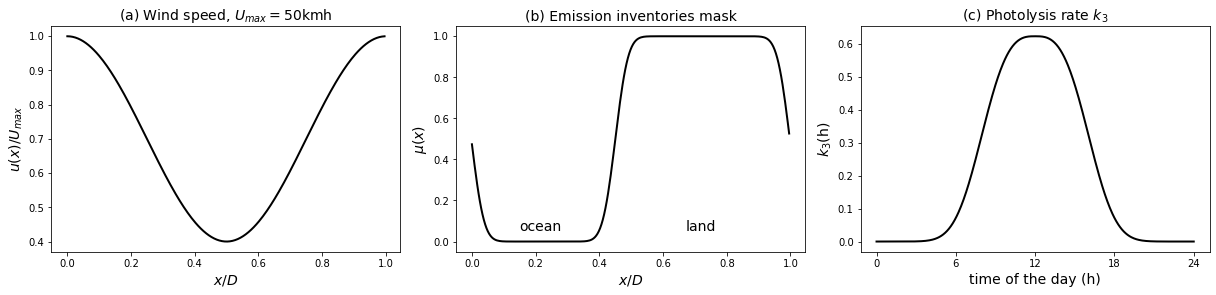

In [37]:
fig, ax = plt.subplots(1,3,figsize=(17,4.2))

ax[0].set_xlabel(r'$x/D$',fontsize=14)
ax[0].set_title(r"(a) Wind speed, $U_{max}=$50kmh",fontsize=14)
ax[0].set_ylabel(r"$u(x)/U_{max}$",fontsize=14)
ax[1].set_xlabel(r'$x/D$',fontsize=14)
ax[1].set_title("(b) Emission inventories mask",fontsize=14)
ax[1].set_ylabel(r"$\mu(x)$",fontsize=14)
ax[1].text(0.15,0.05,'ocean',fontsize=14)
ax[1].text(0.67,0.05,'land',fontsize=14)
ax[2].set_xlabel(r'time of the day (h)',fontsize=14) ;
ax[2].set_title("(c) Photolysis rate $k_3$",fontsize=14)
ax[2].set_ylabel(r"$k_3($h$)$",fontsize=14) ;ax[2].set_xticks([0.,6.,12.,18.,24.])

ax[0].plot(domain.x[0], u/u.max(),linewidth=2,c='k')
ax[1].plot(domain.x[0], cadastre,linewidth=2,c='k')
from module.generated_models.adv_grs import k3
tt = np.linspace(0,24,500);
ax[2].plot(tt, k3(tt)/60,linewidth=2,c='k')

fig.tight_layout();
fig.savefig('../figures/grs_settings.png')

## 2.4 Forecasting filters 

#### EnKF initial state :

In [11]:
ensemble_size = 1600
print('standard deviation for the ensemble : {:.2%}'.format( (1/ensemble_size)**.5) )

ensemble0 = np.array([ initial_settings['Mean concentration'][field] +
                      make_samples(ensemble_size,
                                   domain.x[0],
                                   initial_settings['Length-scale'][field])
                      * initial_settings['Std'][field] for field in species_name])

standard deviation for the ensemble : 2.50%


####  PKF initial state: 

In [12]:
mean_states0    = [initial_settings['Mean concentration'][field] for field in species_name]
var0            = [initial_settings['Std'][field]**2 for field in species_name]
covariance0     = 15*[np.zeros(Nx)]
aspect_tensors0 = [initial_settings['Length-scale'][field]**2 for field in species_name]

pkf_state0 = np.array(mean_states0 + var0 + covariance0 + aspect_tensors0)

#### Initializing filters :

In [13]:
enkf = AdvectionGRS(u, cadastre)
enkf.dt = 1e-4

In [14]:
obs_network = (np.linspace(0.1,0.9,4)*Nx).astype(int)
SPECIE = 'NO2'
obs_species = len(obs_network)*[SPECIE]

times = enkf.window(72.0)
saved_times = times[::1666] + [times[-1]]

In [19]:
saved_times2 = times[::166] + [times[-1]]

#### Forecast EnKF

In [29]:
save_path = 'grs_data/traj_enkf.pkl'

In [30]:
import pickle
traj_enkf = enkf.forecast(times, ensemble0, saved_times, save_path, saved_times2)
pickle.dump(traj_enkf,open('grs_data/traj_enkf.pkl','wb'))
diag_enkf = enkf.diagnosis(traj_enkf, obs_network, obs_species)
pickle.dump(diag_enkf,open('grs_data/diag_enkf.pkl','wb'))

720000it [39:35:54,  5.05it/s] [39:35:54<00:00,  5.58it/s]    
100%|██████████| 720000/720000 [39:35:54<00:00,  5.05it/s]


#### Forecast PKF

In [31]:
pkf = PKF_Advection_GRS(shape=(Nx,),u=u)
traj_pkf = pkf.forecast(times, pkf_state0, saved_times)
rendered_traj_pkf = pkf.render_traj(traj_pkf, obs_network, obs_species)

import pickle
pickle.dump(traj_pkf,open('grs_data/traj_pkf.pkl','wb'))
pickle.dump(rendered_traj_pkf,open('grs_data/rendered_traj_pkf.pkl','wb'))

### or loading forecasts

In [15]:
import pickle
diag_enkf = pickle.load(open('grs_data/diag_enkf.pkl','rb'))
traj_enkf = pickle.load(open('grs_data/traj_enkf.pkl','rb'))
traj_pkf = pickle.load(open('grs_data/traj_pkf.pkl','rb'))
rendered_traj_pkf = pickle.load(open('grs_data/rendered_traj_pkf.pkl','rb'))

# 3. Ploting

## 3.1 ploting function for video

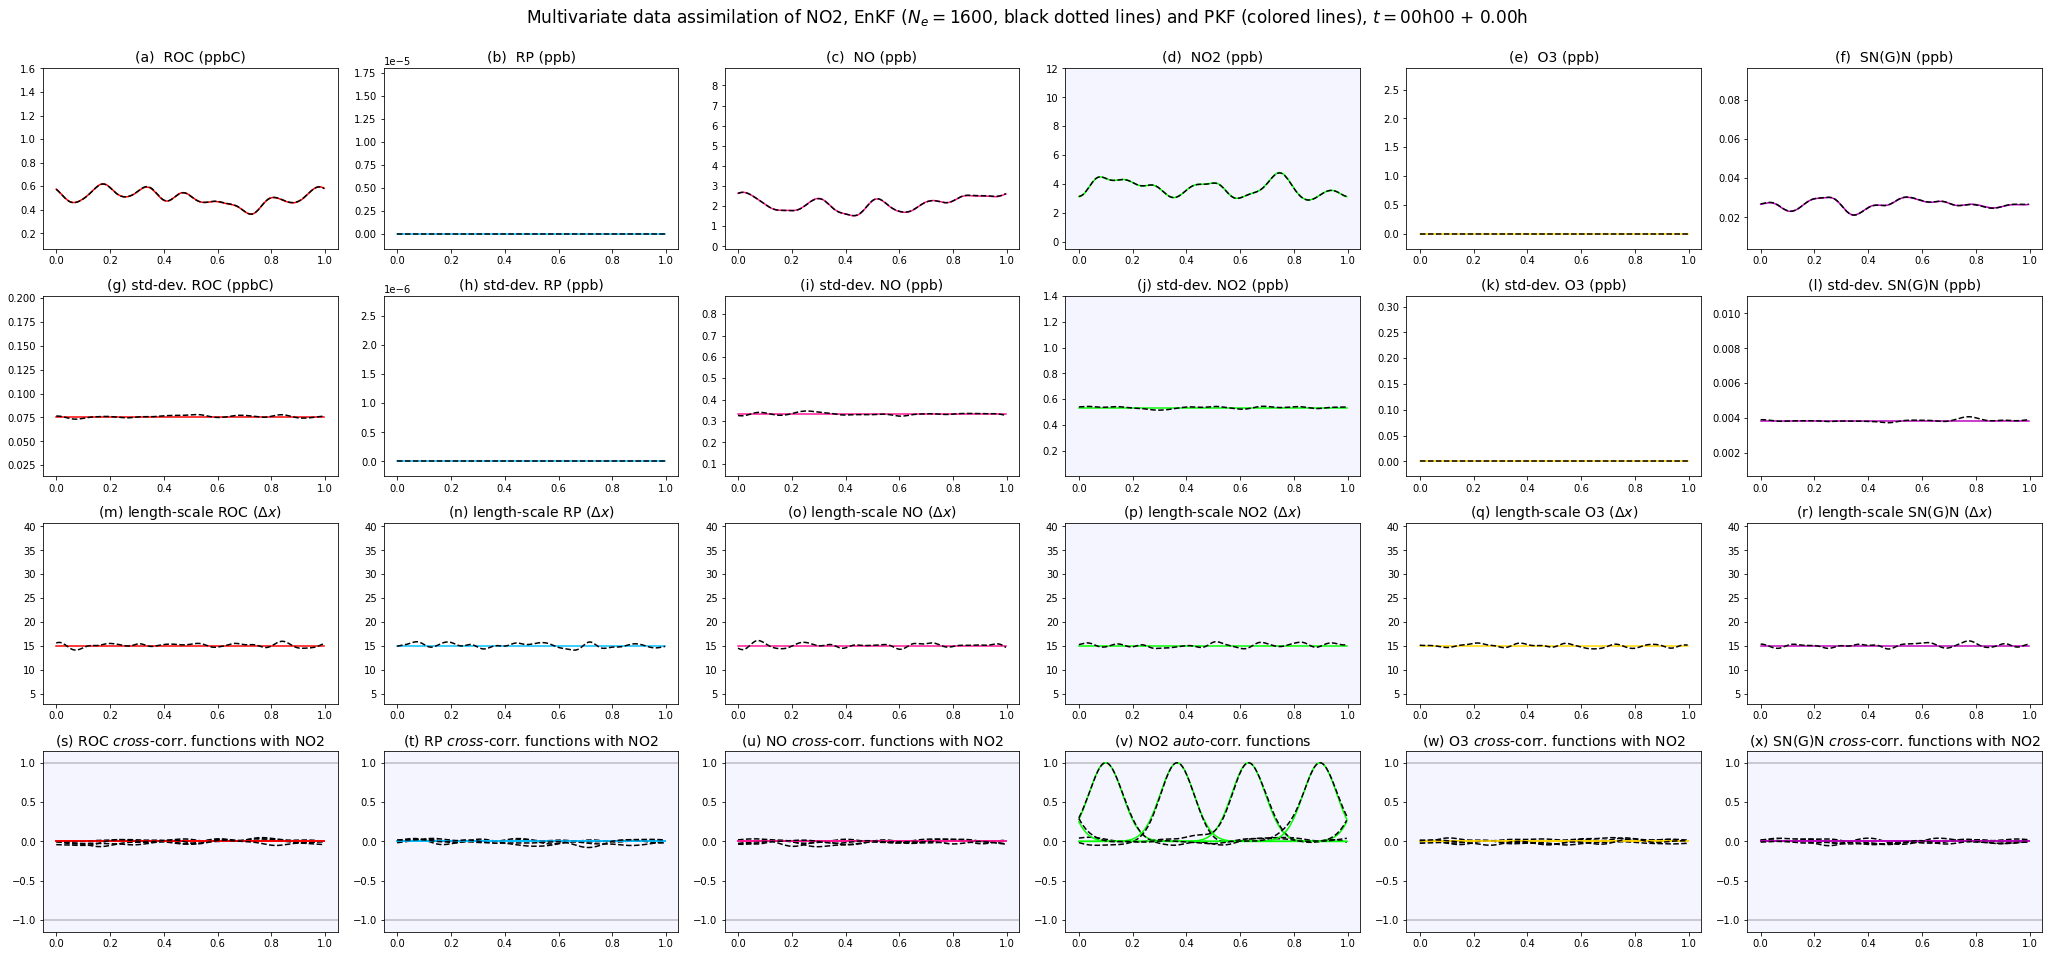

In [16]:
from copy import deepcopy
subplot_lims = deepcopy(initial_settings)

for tf in subplot_lims.keys():
    for sp in species_name : subplot_lims[tf][sp] = (np.inf,-np.inf)

for t, diag in rendered_traj_pkf.items():
    for tf in subplot_lims.keys():
        for sp in species_name : 
            _min, _max = subplot_lims[tf][sp]
            if diag[tf][sp].min()/normalization[tf][sp] < _min: _min = diag[tf][sp].min()/normalization[tf][sp]
            if diag[tf][sp].max()/normalization[tf][sp] > _max: _max = diag[tf][sp].max()/normalization[tf][sp]
            subplot_lims[tf][sp] = (_min, _max)

for tf in subplot_lims.keys():
    for sp in species_name :
        _min, _max = subplot_lims[tf][sp]
        amp = _max - _min
        subplot_lims[tf][sp] = (_min - 0.1*amp, _max+0.1*amp)        

titles = {t : fr'Multivariate data assimilation of {SPECIE}, EnKF ($N_e=${ensemble_size}, black dotted lines) and PKF (colored lines), $t=$00h00 + {t:.2f}h' for t in rendered_traj_pkf.keys()}

# normalization = initial_settings

times = list(rendered_traj_pkf.keys())


#colors
colors = {'ROC':'red',
          'RP':'deepskyblue',
         'NO':'deeppink',
         'NO2':'lime',
         'O3':'gold',
         'SN(G)N':'m'}


species_name = list(colors.keys())
colors2 = {}
for field in species_name : colors2[field] = 'gray'
import string
def make_plot(t, title=None):
    alpha=1
    width=13.5
    fig, ax = plt.subplots(4,6,figsize=(19/9 * width,width))
    panels_index = [f'({c}) ' for c in string.ascii_letters[:24]]
    for i, sn in enumerate(species_name):
        ax[3,i].axhline(1,c='grey',alpha=0.5)
        if sn != SPECIE : ax[3,i].axhline(-1,c='grey',alpha=0.5)
        if sn == SPECIE :
            for j in range(3) : ax[j,i].set_facecolor((0.96,0.96,1))
            for j in range(6) : ax[3,j].set_facecolor((0.96,0.96,1))

        for j, (nam, field) in enumerate(zip(['Mean concentration','Std','Length-scale'],
                                             ['','std-dev.','length-scale'])):

            ax[j,i].set_title(panels_index[j*6 + i] +''+ field +' '+ sn + unities[nam][sn],fontsize=14)
            ax[j,i].set_ylim(subplot_lims[nam][sn])
            ax[j,i].plot(domain.x[0], rendered_traj_pkf[t][nam][sn]/normalization[nam][sn],c=colors[sn],alpha=alpha)
            ax[j,i].plot(domain.x[0], diag_enkf[t][nam][sn]/normalization[nam][sn],c='k',linestyle='--',alpha=alpha)
        for loc in obs_network:
            ax[3,i].set_ylim(-1.15,1.15)
            if sn == SPECIE :
                _title = panels_index[i + 3*6] + SPECIE+ ' $\it{auto}$-corr. functions'
            else:
                _title = panels_index[i + 3*6] + sn+ ' $\it{cross}$-corr. functions with '+ SPECIE 
            ax[3,i].set_title(_title, fontsize=14)

            ax[3,i].plot(domain.x[0], rendered_traj_pkf[t]['Correlation functions'][loc][SPECIE+'/'+sn],c=colors[sn],alpha=alpha)
            ax[3,i].plot(domain.x[0], diag_enkf[t]['Correlation functions'][loc][SPECIE+'/'+sn],linestyle='--',c='k',alpha=alpha)        

    fig.suptitle(titles[t] +'\n', fontsize=17)
    fig.tight_layout();        
    
    return fig;

make_plot(0);

## 3.2 vertical ploting function for the article

plot times: [59.976000000000006, 65.9736]
[11.976  17.9736]


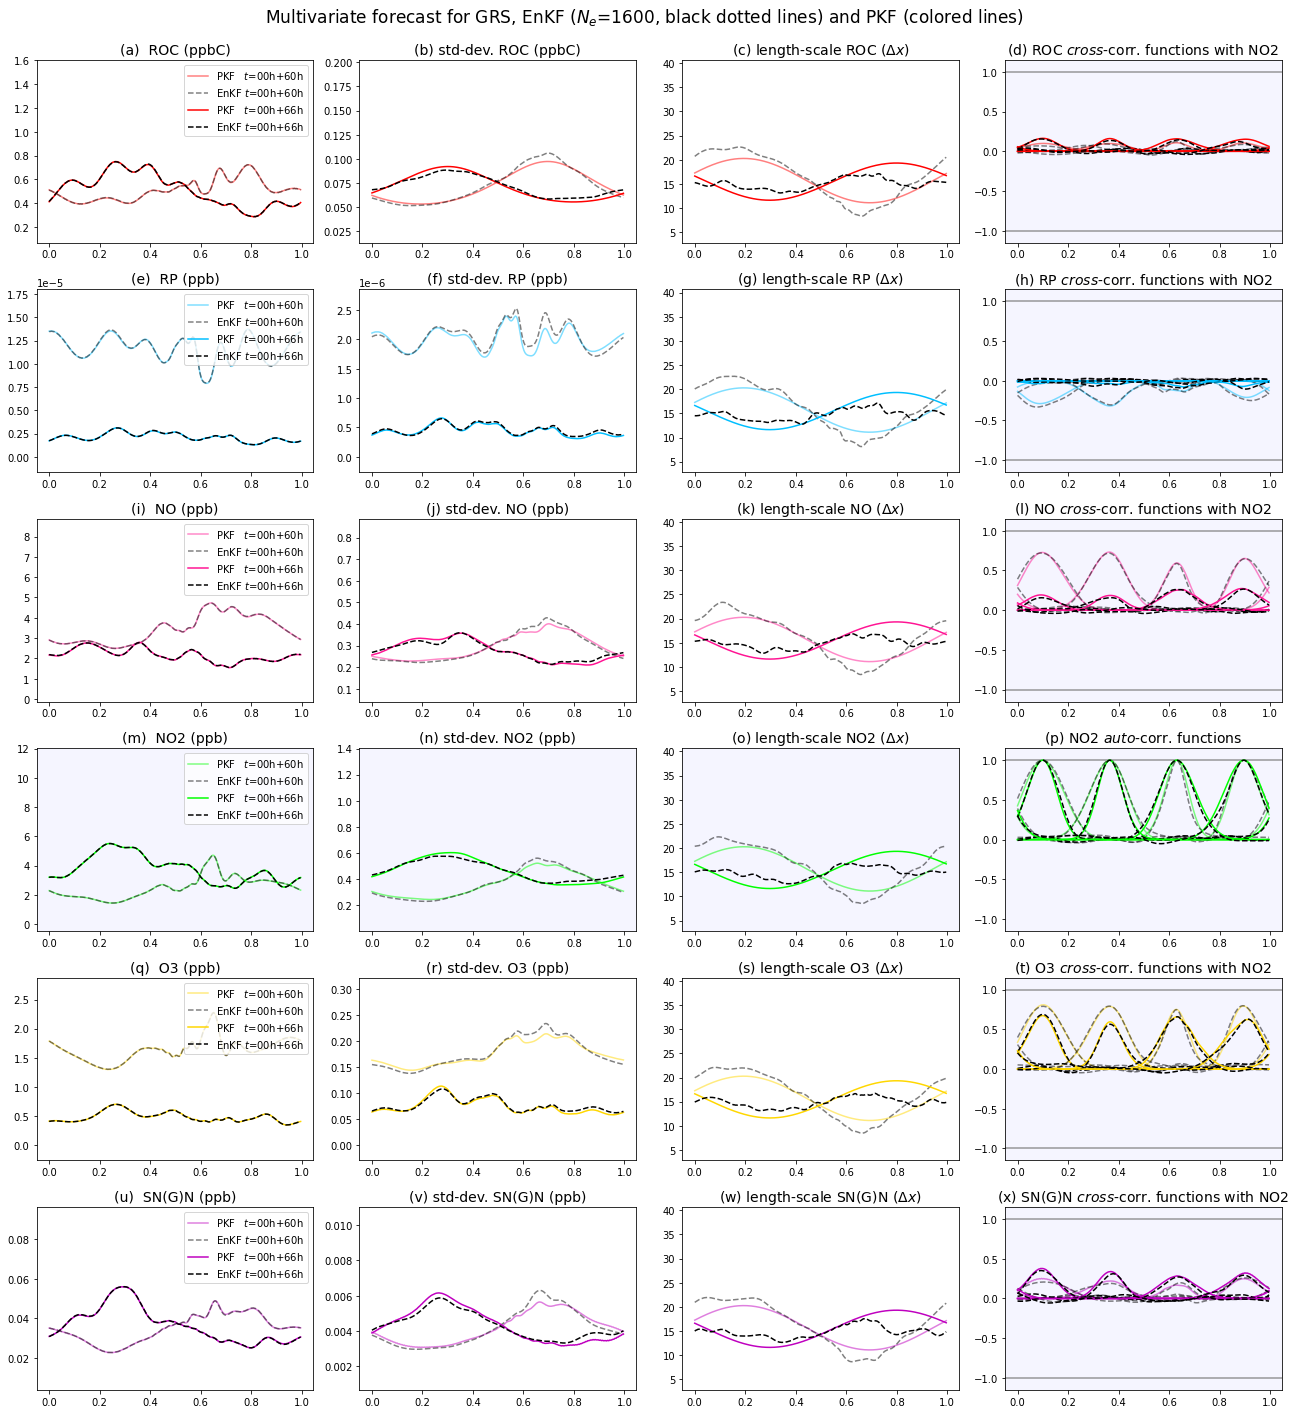

In [18]:
def make_plot_vertical(times, title=None,alphas=None):
    width=18
    
    fig, ax = plt.subplots(6,4,figsize=(width,width*10/9))
    panels_index = [f'({c}) ' for c in string.ascii_letters[:24]]
    alphas = [t / times[-1] for t in times] if alphas is None else alphas
    for t, alpha in zip(times, alphas): 
        for i, sn in enumerate(species_name):
            ax[i,3].axhline(1,c='grey',alpha=0.5)
            if sn != SPECIE : ax[i,3].axhline(-1,c='grey',alpha=0.5)
            if sn == SPECIE :
                for j in range(3) : ax[i,j].set_facecolor((0.96,0.96,1))
                for j in range(6) : ax[j,3].set_facecolor((0.96,0.96,1))

            for j, (nam, field) in enumerate(zip(['Mean concentration','Std','Length-scale'],
                                                 ['','std-dev.','length-scale'])):
                time_label = r'$t$=00h+{:.0f}h'.format(t) 
                
                ax[i,j].set_title(panels_index[j + i*4] +''+ field +' '+ sn + unities[nam][sn],fontsize=14)
                ax[i,j].set_ylim(subplot_lims[nam][sn])
                ax[i,j].plot(domain.x[0], rendered_traj_pkf[t][nam][sn]/normalization[nam][sn],c=colors[sn],alpha=alpha,label='PKF   '+time_label)
                ax[i,j].plot(domain.x[0], diag_enkf[t][nam][sn]/normalization[nam][sn],c='k',linestyle='--',alpha=alpha,label='EnKF '+time_label)
                if j == 0: ax[i,j].legend(loc='upper right');
            for loc in obs_network:
                ax[i,3].set_ylim(-1.15,1.15)
                if sn == SPECIE :
                    _title = panels_index[i*4 + 3] + SPECIE+ ' $\it{auto}$-corr. functions'
                else:
                    _title = panels_index[i*4 + 3] + sn+ ' $\it{cross}$-corr. functions with '+ SPECIE 
                ax[i,3].set_title(_title, fontsize=14)

                ax[i,3].plot(domain.x[0], rendered_traj_pkf[t]['Correlation functions'][loc][SPECIE+'/'+sn],c=colors[sn],alpha=alpha)
                ax[i,3].plot(domain.x[0], diag_enkf[t]['Correlation functions'][loc][SPECIE+'/'+sn],linestyle='--',c='k',alpha=alpha)        

    fig.suptitle(title +'\n', fontsize=17)
    fig.tight_layout();        
    
    return fig;


times = list(diag_enkf.keys())

stops = 3
indexs = np.linspace(0,len(times)-2, stops +1 ).astype(int)[1:]
times2 = [times[index] for index in indexs]

title1 = r'Multivariate forecast for GRS, EnKF ($N_e$={}, black dotted lines) and PKF (colored lines)'.format(ensemble_size)
# title2 = r'Multivariate forecast for GRS, EnKF (black dotted lines) and PKF (colored lines), $t=[{:.2f}, {:.2f}]$h'.format(times2[2],times2[3])

times2 = list(np.array(list(traj_enkf.keys()))[[72*5,72*5+36]])
alphas = [0.5,1]
fig = make_plot_vertical(times2, title=title1,alphas=alphas);
print("plot times:",times2)
print(np.array(times2)%24)
fig.savefig('../figures/grs_forecast_vertical.png')

## 3.3 video generation

In [ ]:
from model.ploting_functions.utils import *

times = list(rendered_traj_pkf.keys())

saving_dir = 'plots/'
img_name= 'GRS_forecast'

ploting_args = (None,)

save_plots(saving_dir, img_name, make_plot, times, titles, ploting_args)

make_video(imgs_dir = saving_dir, output_dir='video_plots/',
           output_filename = img_name,fps = 20)